**Compare different Optimizers for the Attack**

Adam Optimizer

Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4083 - loss: 1.0624
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5079 - loss: 0.9584
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5486 - loss: 0.8972
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5852 - loss: 0.8323
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6134 - loss: 0.7797
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6185 - loss: 0.7624
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6317 - loss: 0.7229
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6468 - loss: 0.7062
Epoch 9/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6421 - loss: 0.6902
Epoch 10/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6544 - loss: 0.6769
Epoch 11/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6601 - loss: 0.6643
Epoch 12/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

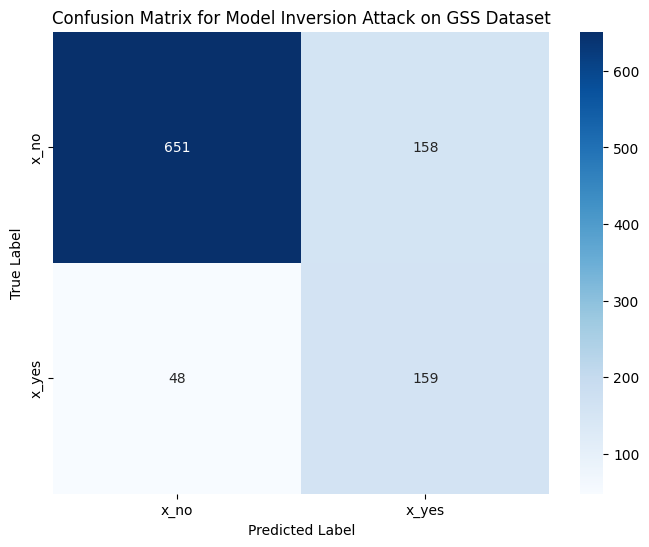

Classification Report:
               precision    recall  f1-score   support

        x_no       0.93      0.80      0.86       809
       x_yes       0.50      0.77      0.61       207

    accuracy                           0.80      1016
   macro avg       0.72      0.79      0.74      1016
weighted avg       0.84      0.80      0.81      1016



In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

file_path = 'GSS_5079.csv'
gss_data = pd.read_csv(file_path)

X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()


sensitive_encoder = OneHotEncoder(sparse_output=False)
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))


target_encoder = OneHotEncoder(sparse_output=False)
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))


X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Compute class weights to balance dataset
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define the target model
input_dim = X_train.shape[1]
target_model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(y_encoded.shape[1], activation='softmax')
])

target_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


target_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


test_loss, test_accuracy = target_model.evaluate(X_test, y_test, verbose=1)
print(f"Target Model - Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")

# BLACK-BOX MODEL INVERSION ATTACK --
# Step 1: Query the target model to get its predictions
predicted_probabilities = target_model.predict(X_test)

# Step 2: Train the inversion model
X_inversion = np.hstack((X_test, predicted_probabilities.reshape(-1, predicted_probabilities.shape[1])))
y_inversion = sensitive_test  # The actual sensitive attributes

# Define the inversion model
inversion_model = models.Sequential([
    layers.Input(shape=(X_inversion.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(sensitive_test.shape[1], activation='softmax')   for sensitive attribute
])

inversion_model.compile(optimizer=Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


inversion_model.fit(X_inversion, y_inversion, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)

# Evaluate the inversion model
sensitive_pred = inversion_model.predict(X_inversion)
threshold = 0.6
sensitive_pred_labels = (sensitive_pred[:, 1] > threshold).astype(int)
sensitive_true_labels = np.argmax(y_inversion, axis=1)
inversion_accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
print(f"Inversion Model - Accuracy: {inversion_accuracy:.2f}")


conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)


class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])


plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sensitive_encoder.categories_[0], yticklabels=sensitive_encoder.categories_[0])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Model Inversion Attack on GSS Dataset")
plt.show()


print("Classification Report:\n", class_report)


SGD Optimizer

Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3220 - loss: 1.1240
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3268 - loss: 1.1082
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3575 - loss: 1.1019
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3616 - loss: 1.1002
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3700 - loss: 1.0940
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3815 - loss: 1.0912
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3853 - loss: 1.0900
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3874 - loss: 1.0862
Epoch 9/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4065 - loss: 1.0823
Epoch 10/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4039 - loss: 1.0830
Epoch 11/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4103 - loss: 1.0813
Epoch 12/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

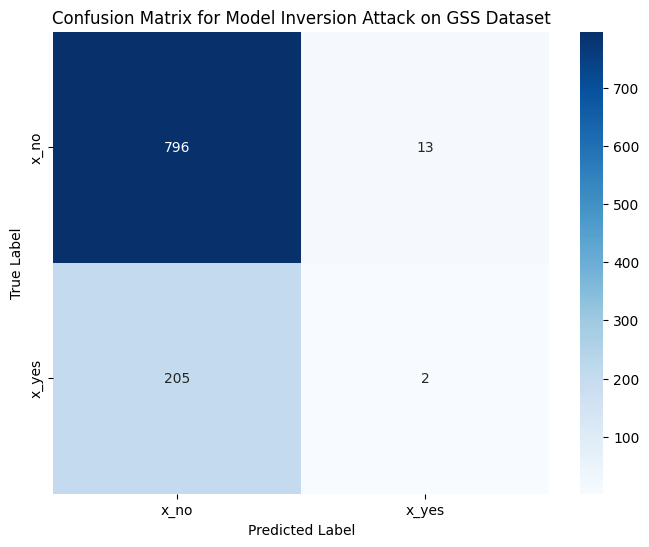

Classification Report:
               precision    recall  f1-score   support

        x_no       0.80      0.98      0.88       809
       x_yes       0.13      0.01      0.02       207

    accuracy                           0.79      1016
   macro avg       0.46      0.50      0.45      1016
weighted avg       0.66      0.79      0.70      1016



In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, RMSprop, SGD


file_path = 'GSS_5079.csv'
gss_data = pd.read_csv(file_path)

X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()


sensitive_encoder = OneHotEncoder(sparse_output=False)
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))


target_encoder = OneHotEncoder(sparse_output=False)
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))


X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Compute class weights to balance dataset
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define the target model
input_dim = X_train.shape[1]
target_model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(y_encoded.shape[1], activation='softmax')
])

target_model.compile(optimizer=SGD(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


target_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


test_loss, test_accuracy = target_model.evaluate(X_test, y_test, verbose=1)
print(f"Target Model - Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")

# BLACK-BOX MODEL INVERSION ATTACK
# Step 1: Query the target model to get its predictions
predicted_probabilities = target_model.predict(X_test)

# Step 2: Train the inversion model
X_inversion = np.hstack((X_test, predicted_probabilities.reshape(-1, predicted_probabilities.shape[1])))
y_inversion = sensitive_test  # The actual sensitive attributes

# Define the inversion model
inversion_model = models.Sequential([
    layers.Input(shape=(X_inversion.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(sensitive_test.shape[1], activation='softmax')   for sensitive attribute
])

inversion_model.compile(optimizer=SGD(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


inversion_model.fit(X_inversion, y_inversion, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)

# Evaluate the inversion model
sensitive_pred = inversion_model.predict(X_inversion)
threshold = 0.6
sensitive_pred_labels = (sensitive_pred[:, 1] > threshold).astype(int)
sensitive_true_labels = np.argmax(y_inversion, axis=1)
inversion_accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
print(f"Inversion Model - Accuracy: {inversion_accuracy:.2f}")


conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)


class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])


plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sensitive_encoder.categories_[0], yticklabels=sensitive_encoder.categories_[0])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Model Inversion Attack on GSS Dataset")
plt.show()


print("Classification Report:\n", class_report)


Adadelta Optimizer

Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3252 - loss: 1.1244
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3295 - loss: 1.1213
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3345 - loss: 1.1174
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3251 - loss: 1.1170
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3236 - loss: 1.1177
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3357 - loss: 1.1138
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3362 - loss: 1.1102
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3343 - loss: 1.1103
Epoch 9/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3268 - loss: 1.1092
Epoch 10/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3293 - loss: 1.1099
Epoch 11/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3299 - loss: 1.1096
Epoch 12/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

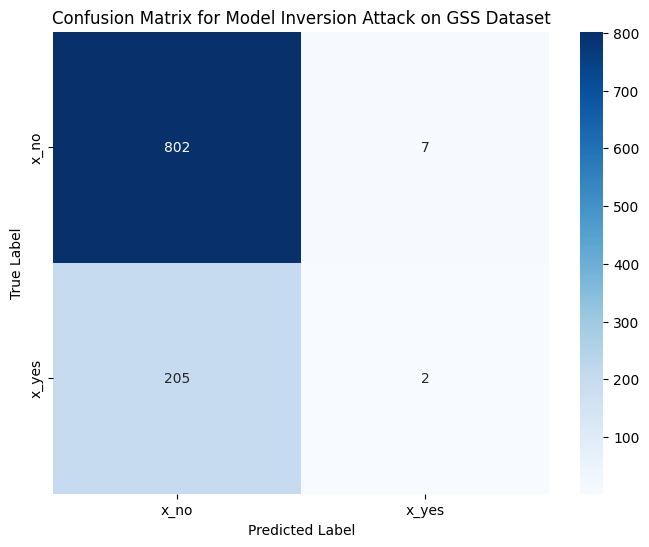

Classification Report:
               precision    recall  f1-score   support

        x_no       0.80      0.99      0.88       809
       x_yes       0.22      0.01      0.02       207

    accuracy                           0.79      1016
   macro avg       0.51      0.50      0.45      1016
weighted avg       0.68      0.79      0.71      1016



In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, RMSprop, SGD


file_path = 'GSS_5079.csv'
gss_data = pd.read_csv(file_path)

X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()


sensitive_encoder = OneHotEncoder(sparse_output=False)
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))


target_encoder = OneHotEncoder(sparse_output=False)
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))


X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Compute class weights to balance dataset
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define the target model
input_dim = X_train.shape[1]
target_model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(y_encoded.shape[1], activation='softmax')
])

target_model.compile(optimizer=Adadelta(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


target_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


test_loss, test_accuracy = target_model.evaluate(X_test, y_test, verbose=1)
print(f"Target Model - Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")

# BLACK-BOX MODEL INVERSION ATTACK
# Step 1: Query the target model to get its predictions
predicted_probabilities = target_model.predict(X_test)

# Step 2: Train the inversion model
X_inversion = np.hstack((X_test, predicted_probabilities.reshape(-1, predicted_probabilities.shape[1])))
y_inversion = sensitive_test  # The actual sensitive attributes

# Define the inversion model
inversion_model = models.Sequential([
    layers.Input(shape=(X_inversion.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(sensitive_test.shape[1], activation='softmax')   for sensitive attribute
])

inversion_model.compile(optimizer=Adadelta(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


inversion_model.fit(X_inversion, y_inversion, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)

# Evaluate the inversion model
sensitive_pred = inversion_model.predict(X_inversion)
threshold = 0.6
sensitive_pred_labels = (sensitive_pred[:, 1] > threshold).astype(int)
sensitive_true_labels = np.argmax(y_inversion, axis=1)
inversion_accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
print(f"Inversion Model - Accuracy: {inversion_accuracy:.2f}")


conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)


class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])


plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sensitive_encoder.categories_[0], yticklabels=sensitive_encoder.categories_[0])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Model Inversion Attack on GSS Dataset")
plt.show()


print("Classification Report:\n", class_report)


Adagrad Optimizer

Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3564 - loss: 1.0981
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3834 - loss: 1.0892
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4125 - loss: 1.0825
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4226 - loss: 1.0785
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4238 - loss: 1.0759
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4358 - loss: 1.0686
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4377 - loss: 1.0648
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4447 - loss: 1.0606
Epoch 9/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4431 - loss: 1.0589
Epoch 10/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4567 - loss: 1.0516
Epoch 11/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4515 - loss: 1.0526
Epoch 12/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

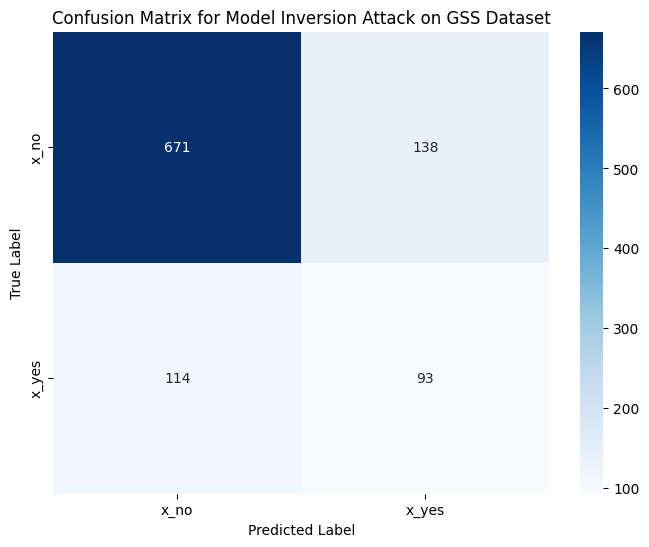

Classification Report:
               precision    recall  f1-score   support

        x_no       0.85      0.83      0.84       809
       x_yes       0.40      0.45      0.42       207

    accuracy                           0.75      1016
   macro avg       0.63      0.64      0.63      1016
weighted avg       0.76      0.75      0.76      1016



In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, RMSprop, SGD


file_path = 'GSS_5079.csv'
gss_data = pd.read_csv(file_path)

X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()


sensitive_encoder = OneHotEncoder(sparse_output=False)
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))


target_encoder = OneHotEncoder(sparse_output=False)
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))


X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Compute class weights to balance dataset
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define the target model
input_dim = X_train.shape[1]
target_model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(y_encoded.shape[1], activation='softmax')
])

target_model.compile(optimizer=Adagrad(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


target_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


test_loss, test_accuracy = target_model.evaluate(X_test, y_test, verbose=1)
print(f"Target Model - Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")

# BLACK-BOX MODEL INVERSION ATTACK
# Step 1: Query the target model to get its predictions
predicted_probabilities = target_model.predict(X_test)

# Step 2: Train the inversion model
X_inversion = np.hstack((X_test, predicted_probabilities.reshape(-1, predicted_probabilities.shape[1])))
y_inversion = sensitive_test  # The actual sensitive attributes

# Define the inversion model
inversion_model = models.Sequential([
    layers.Input(shape=(X_inversion.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(sensitive_test.shape[1], activation='softmax')   for sensitive attribute
])

inversion_model.compile(optimizer=Adagrad(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


inversion_model.fit(X_inversion, y_inversion, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)

# Evaluate the inversion model
sensitive_pred = inversion_model.predict(X_inversion)
threshold = 0.6
sensitive_pred_labels = (sensitive_pred[:, 1] > threshold).astype(int)
sensitive_true_labels = np.argmax(y_inversion, axis=1)
inversion_accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
print(f"Inversion Model - Accuracy: {inversion_accuracy:.2f}")


conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)


class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])


plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sensitive_encoder.categories_[0], yticklabels=sensitive_encoder.categories_[0])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Model Inversion Attack on GSS Dataset")
plt.show()


print("Classification Report:\n", class_report)


RMSprop Optimizer

Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4269 - loss: 1.0522
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5112 - loss: 0.9701
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5310 - loss: 0.9159
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5676 - loss: 0.8582
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5873 - loss: 0.8247
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6011 - loss: 0.7954
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6065 - loss: 0.7722
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6328 - loss: 0.7339
Epoch 9/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6374 - loss: 0.7249
Epoch 10/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6359 - loss: 0.7212
Epoch 11/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6441 - loss: 0.7036
Epoch 12/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

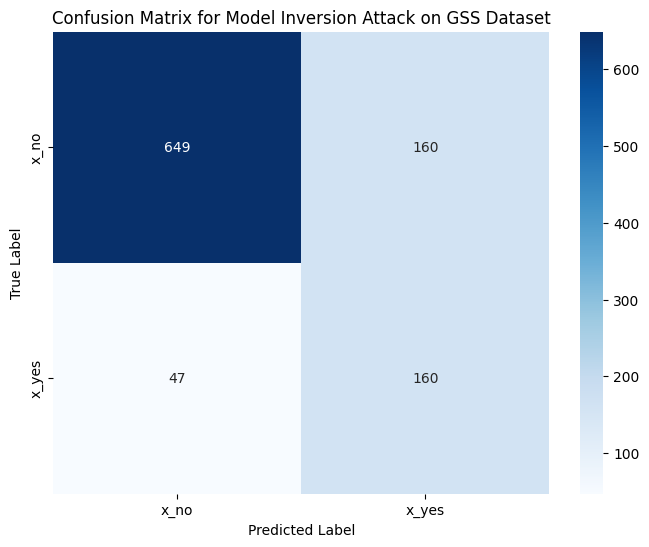

Classification Report:
               precision    recall  f1-score   support

        x_no       0.93      0.80      0.86       809
       x_yes       0.50      0.77      0.61       207

    accuracy                           0.80      1016
   macro avg       0.72      0.79      0.73      1016
weighted avg       0.84      0.80      0.81      1016



In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, RMSprop, SGD


file_path = 'GSS_5079.csv'
gss_data = pd.read_csv(file_path)

X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()


sensitive_encoder = OneHotEncoder(sparse_output=False)
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))


target_encoder = OneHotEncoder(sparse_output=False)
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))


X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Compute class weights to balance dataset
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define the target model
input_dim = X_train.shape[1]
target_model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(y_encoded.shape[1], activation='softmax')
])

target_model.compile(optimizer=RMSprop(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


target_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


test_loss, test_accuracy = target_model.evaluate(X_test, y_test, verbose=1)
print(f"Target Model - Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")

# BLACK-BOX MODEL INVERSION ATTACK
# Step 1: Query the target model to get its predictions
predicted_probabilities = target_model.predict(X_test)

# Step 2: Train the inversion model
X_inversion = np.hstack((X_test, predicted_probabilities.reshape(-1, predicted_probabilities.shape[1])))
y_inversion = sensitive_test  # The actual sensitive attributes

# Define the inversion model
inversion_model = models.Sequential([
    layers.Input(shape=(X_inversion.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(sensitive_test.shape[1], activation='softmax')   for sensitive attribute
])

inversion_model.compile(optimizer=RMSprop(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


inversion_model.fit(X_inversion, y_inversion, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)

# Evaluate the inversion model
sensitive_pred = inversion_model.predict(X_inversion)
threshold = 0.6
sensitive_pred_labels = (sensitive_pred[:, 1] > threshold).astype(int)
sensitive_true_labels = np.argmax(y_inversion, axis=1)
inversion_accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
print(f"Inversion Model - Accuracy: {inversion_accuracy:.2f}")


conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)


class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])


plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sensitive_encoder.categories_[0], yticklabels=sensitive_encoder.categories_[0])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Model Inversion Attack on GSS Dataset")
plt.show()


print("Classification Report:\n", class_report)
